In [1]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
from jax.scipy.ndimage import map_coordinates
import h5py
'unset XLA_FLAGS'

from jax.config import config
config.update("jax_enable_x64", True)


import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


In [2]:

lognormal_params = np.loadtxt('/gpfs7kw/linkhome/rech/genmfd01/ulm75uc/sbi_lens/sbi_lens/data/lognormal_shift.csv', skiprows=1, delimiter=',').reshape([8,8,3])



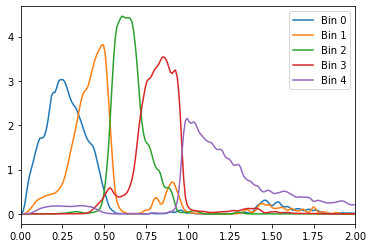

In [3]:
# Reading the DC2 tomographic bins into redshift distribution objects
with h5py.File("shear_photoz_stack.hdf5") as f:
    group = f["n_of_z"]
    # Read the z grid
    source = group["source"]
    z_shear = source['z'][::]
    # Read the true n(z)
    nz_shear = [jc.redshift.kde_nz(z_shear,  
                                   source[f"bin_{i}"][:], 
                                   bw=0.01, zmax=2.5) for i in range(5)] 
for i in range(5):
  plot(z_shear, nz_shear[i](z_shear), color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,2);

In [4]:
# Here we add the code that interpolates the shift parameters as a function of cosmology
@jax.jit
def shift_fn(omega_m, sigma_8):
  omega_m = jnp.atleast_1d(omega_m)
  sigma_8 = jnp.atleast_1d(sigma_8) 
  return map_coordinates(lognormal_params[:,:,2], jnp.stack([(omega_m - 0.2) / 0.2*8 - 0.5,
                                                             (sigma_8 - 0.6) / 0.4*8 - 0.5], 
                                                            axis=0).reshape([2,-1]) , order=1, mode='nearest').squeeze()

In [5]:
def make_power_map(pk_fn, N, map_size, zero_freq_val=0.0, model_type=None ):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=map_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    if model_type=='no_correlation':
        power_map = ps_map * (N / map_size)**2
    else:
        power_map = ps_map * (N / map_size)
    return power_map

def make_lognormal_power_map(power_map, shift, zero_freq_val=0.0):
    power_spectrum_for_lognorm = jnp.fft.ifft2(power_map).real
    power_spectrum_for_lognorm = jnp.log(1 +
                                         power_spectrum_for_lognorm / shift**2)
    power_spectrum_for_lognorm = jnp.abs(
        jnp.fft.fft2(power_spectrum_for_lognorm))
    power_spectrum_for_lognorm = power_spectrum_for_lognorm.at[0, 0].set(0.)
    return power_spectrum_for_lognorm


def cls2cov(nb,cell,nl):
        subcov = np.zeros((nb,nb))
        index = np.triu_indices_from(subcov)
        clscov=np.zeros((nl,nb,nb))
        for i,j in enumerate(zip(*index)):
            clscov[:,j[0],j[1]]=cell[:,:][i]
            clscov[:,j[1],j[0]]=cell[:,:][i]   
        return  clscov    

def make_lognormal_cl(cl,shift):
    xsi = jnp.fft.ifft(cl)
    xsi_shift = jnp.log(1 + xsi/(shift)**2)
    cl_shifted = jnp.fft.fft(xsi_shift).real
    return  cl_shifted

In [6]:
#some useful functions to make the plot

def fill_lower_and_diag(array,nl):
    n = int(np.sqrt(len(array)*2))
    mask = np.arange(n)[:,None] >= np.arange(n)
    out = np.zeros((n,n,nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T


def fill_lower_diag(array,nl):
    n = int(np.sqrt(len(array)*2))+1
    mask = np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n, nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T

In [7]:
n_z_bins=len(nz_shear)

In [8]:
def model(N=128,              
          map_size=5,      
          gal_per_arcmin2=30,   
          sigma_e=0.02,
          model_type=None):   
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians
    omega_c = numpyro.sample('omega_c', dist.Normal(0.3, 0.05))
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0.8, 0.05)) 
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    ell_tab = 2 * jnp.pi * abs(jnp.fft.fftfreq(N, d=map_size / N))
    n_nz_bins=1
    tracer = jc.probes.WeakLensing([nz_shear[-1]])
    shift = shift_fn(cosmo.Omega_m, sigma_8)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer]) 
    cell_tab= make_lognormal_cl(cell_tab, shift)[:, 1:]
    Sigma=cls2cov(n_nz_bins,cell_tab,len(ell_tab)-1)
    L = np.linalg.cholesky(Sigma)
    power=[]
    for i in range(n_nz_bins):
        for j in range(n_nz_bins):
            P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab[1:], jnp.array(L[:,i][:,j])).reshape(k.shape)
            power_map = make_power_map(P, N, map_size) 
            power.append(power_map)
    z=numpyro.sample('z', dist.MultivariateNormal(loc=jnp.zeros((n_nz_bins,N,N)), precision_matrix=jnp.eye(N)))
    powers=np.reshape(np.stack(power),[n_nz_bins,n_nz_bins,N,N])
    field=(jnp.fft.fft2(z) * powers)
    field=(jnp.fft.ifft2(np.sum(field, axis=1)).real)
    field =  (shift)*(jnp.exp(field - jnp.var(field,axis=(1,2), keepdims=True) / 2) - 1)
    return field




In [9]:
fiducial_model = condition(model, {'omega_c': 0.3, 'sigma_8': 0.8})
sample_map_fiducial = seed(model, jax.random.PRNGKey(42))
m_data= sample_map_fiducial()

In [10]:
theta_max=5
EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)
cmap = cmr.eclipse

In [11]:
m_data.shape

(1, 128, 128)

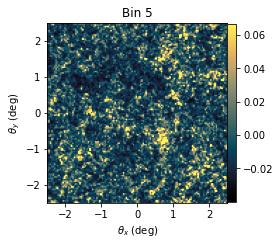

In [12]:

fig, ax = plt.subplots(1,1, figsize=(4, 4))

std_kmap = np.std(m_data[0])
ax.set_title('Bin %d'%(5))
ax.set_xlabel(r'$\theta_x$ (deg)')
ax.set_ylabel(r'$\theta_y$ (deg)')
ax.imshow(m_data[0], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT)
cb = fig.colorbar(ax.imshow(m_data[0], cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
cb.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

### Create N mock realization to average over the final angular power spectrum

In [ ]:
N_sample = 20

Cl_list = []
key=jax.random.PRNGKey(14)
for i in range(N_sample):
    print("===================================================")
    print("Sample %d"%(i+1))
    print("===================================================")
    key,subkey=jax.random.split(key)
    sample_map_fiducial = seed(model, subkey)
    m_data = sample_map_fiducial()
    Cl_list.append(m_data)

### Compare the results with the theory

In [14]:
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
import cmasher as cmr

In [15]:
ell_theory = jnp.linspace(300, 5000, 128)   
cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8)
tracer = jc.probes.WeakLensing([nz_shear[-1]])
cell_theory = jc.angular_cl.angular_cl(cosmo, ell_theory, [tracer])

In [16]:
l_edges_kmap= np.linspace(300, 5000, 128)
ell_sample=ConvergenceMap(m_data[0], angle=5*u.deg).powerSpectrum(l_edges_kmap)[0]

In [17]:
p_auto_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    pi=ConvergenceMap(m_data[0], angle=5*u.deg).powerSpectrum(l_edges_kmap)[1]
    p_auto_sample.append(pi)

In [18]:
Cl_auto_arr = np.array(p_auto_sample)
Cl_mean_auto  = np.mean(Cl_auto_arr, axis=0)
Cl_lower_auto = np.percentile(Cl_auto_arr, 2.5, axis=0)
Cl_upper_auto = np.percentile(Cl_auto_arr, 97.5, axis=0)

In [19]:
col = cmr.eclipse([0.,0,0.55,0.85]) 

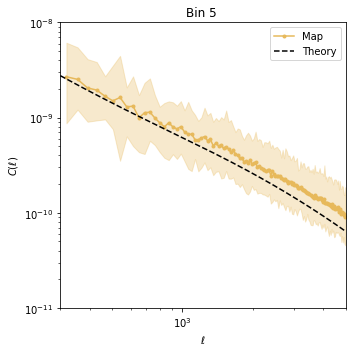

In [26]:
fig, ax = plt.subplots( figsize=(5,5))
ax.set_title('Bin %d '%(5))
ax.set_xlabel('$\ell$')
ax.set_ylabel('$C(\ell)$')
ax.set_xlim(300., 5000.)
ax.set_ylim(1e-11, 1e-8)
ax.loglog(ell_sample, Cl_mean_auto, '.-', color=col[3], label='Map')
ax.loglog(ell_theory, cell_theory[0] , '--',  color=col[1], label='Theory')
ax.fill_between(ell_sample, Cl_lower_auto, Cl_upper_auto, color=col[3], alpha=0.3)
ax.legend()
plt.tight_layout()            
plt.show()   